# NOAA Tide Prediction Shift Based on Wind Speed and Direction

### Objective:
* Determine which wind directions cause a correlated shift to the predicted tide levels

### Process:
* Collect data from NOAA website using API
* Clean and organize into DataFrame
* Calculate difference in predicted tide vs actual tide
* Separate data by wind direction and plot

### API Instructions:
* https://api.tidesandcurrents.noaa.gov/api/prod/


### Load Required Modules

In [11]:
import pandas as pd
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from scipy import stats


### Collect data from NOAA website using API
* Define functions needed to get data
* Break up date into 30 day requests due to a limitation with the API
* Combine looped data into a single CSV file for each product name:
    * water_level.csv
    * predictions.csv
    * wind.csv

Funtion "get_url"
* Takes the input parameters and forms the correct hyperlink for the API to retrieve a CSV file.

In [2]:
def get_url(begin_date, end_date, product, datum, units, time_zone, interval):
    #prepare URL and write to CSV file to DataFrame
    begin_date=datetime.datetime.strftime(begin_date, '%Y%m%d %H:%M')
    end_date=datetime.datetime.strftime(end_date, '%Y%m%d %H:%M')
    api_url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=%s\
&end_date=%s&station=8419317&product=%s&datum=%s&units=%s&time_zone=%s&interval=%s\
&application=web_services&format=csv' % (begin_date, end_date, product, datum, units, time_zone, interval) # this url gives use the tide data
    api_url=api_url.replace(" ", "%20")
    print(product,' URL: ',api_url)
    return (api_url)

Funtion "loop_data"
* Takes the input parameters and breaks that requests up into 30 days chunks.  
* It then calls the "get_url" function which returns the hyperlink for the CVS file.  
* The CSV files are merged into a single dataframe.  This function forms the correct hyperlink for the API to retrieve a CSV file.

In [3]:
def loop_data(begin_date, end_date, product, datum, units, time_zone, interval, name):
    i=1 #counter for the loops
    df=[] #ensures dataframe is empty at start
    begin_date_num=datetime.datetime.strptime(begin_date, '%Y%m%d %H:%M') #convert the string dates into a usable format
    end_date_num=datetime.datetime.strptime(end_date, '%Y%m%d %H:%M')  #convert the string dates into a usable format

    startnew=begin_date_num #create temporary start date to break data into 30 day chunks
    endnew=startnew+datetime.timedelta(days=30) #create temporary end date  which is +30 days from start date
    truefalse=True
    modevar='w'
    while endnew<end_date_num: #Break data into 30 day chunks since it is a limitation of the API
        print('Loop: {} for {}, Start Date: {}, End Date: {}'.format(i,name,startnew,endnew))
        api_url=get_url(startnew, endnew, product, datum, units, time_zone, interval)
        df = pd.read_csv(api_url)
        df.to_csv('{}.csv'.format(name), mode=modevar, header=truefalse) #write dataframe to csv file: df0.csv
        truefalse=False # change the header to false for future loops so the headers don't get repeated in the data
        modevar='a'
        startnew=endnew #change start date to the previous end date +1 day
        endnew=startnew+datetime.timedelta(days=30) #change the end date to start date +30 days
        if endnew>end_date_num: #overwrite intermediate end_date_num with end_date if +30 days caused desired date range to be exceeded
            endnew=end_date_num
        i=i+1  
    print('Loop: {} for {}, Start Date: {}, End Date: {}'.format(i,name,startnew,end_date_num))
    api_url=get_url(startnew, endnew, product, datum, units, time_zone, interval)
    df = pd.read_csv(api_url)
    df.to_csv('{}.csv'.format(name), mode='a', header=False) #write dataframe to csv file: df0.csv
    df = pd.read_csv('{}.csv'.format(name))
    df.columns = df.columns.str.strip()  #remove leading or trailing spaces from column names
    return (df)

Global Input Values

In [4]:
begin_date='20120101 12:00' #Use whole days, begin time should match end time
end_date='20121231 12:00' #Use whole days, begin time should match end time
datum='MLLW' #Mean Lower Low Water
units='english'
time_zone='gmt'
interval='06' #data at 6 minute intervals

Retrieve data using function loop_data

In [5]:
#input for water level request
product='water_level'
name='water_level'
df0=loop_data(begin_date, end_date, product, datum, units, time_zone, interval, name) #call loop_data function, write to df0

#input for predictions request
product='predictions' 
name='predictions'
df1=loop_data(begin_date, end_date, product, datum, units, time_zone, interval, name) #call loop_data function, write to df1

#input for wind request
product='wind'  
datum='null'    #datum not needed for weather
name='wind'
df2=loop_data(begin_date, end_date, product, datum, units, time_zone, interval, name) #call loop_data function, write to df2
df2.rename(columns={'Direction.1':'Direction_Simple'}, inplace=True) #rename column

Loop: 1 for water_level, Start Date: 2012-01-01 12:00:00, End Date: 2012-01-31 12:00:00
water_level  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20120101%2012:00&end_date=20120131%2012:00&station=8419317&product=water_level&datum=MLLW&units=english&time_zone=gmt&interval=06&application=web_services&format=csv
Loop: 2 for water_level, Start Date: 2012-01-31 12:00:00, End Date: 2012-03-01 12:00:00
water_level  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20120131%2012:00&end_date=20120301%2012:00&station=8419317&product=water_level&datum=MLLW&units=english&time_zone=gmt&interval=06&application=web_services&format=csv
Loop: 3 for water_level, Start Date: 2012-03-01 12:00:00, End Date: 2012-03-31 12:00:00
water_level  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20120301%2012:00&end_date=20120331%2012:00&station=8419317&product=water_level&datum=MLLW&units=english&time_zone=gmt&interval=06&applicatio

Loop: 12 for predictions, Start Date: 2012-11-26 12:00:00, End Date: 2012-12-26 12:00:00
predictions  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20121126%2012:00&end_date=20121226%2012:00&station=8419317&product=predictions&datum=MLLW&units=english&time_zone=gmt&interval=06&application=web_services&format=csv
Loop: 13 for predictions, Start Date: 2012-12-26 12:00:00, End Date: 2012-12-31 12:00:00
predictions  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20121226%2012:00&end_date=20121231%2012:00&station=8419317&product=predictions&datum=MLLW&units=english&time_zone=gmt&interval=06&application=web_services&format=csv
Loop: 1 for wind, Start Date: 2012-01-01 12:00:00, End Date: 2012-01-31 12:00:00
wind  URL:  https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20120101%2012:00&end_date=20120131%2012:00&station=8419317&product=wind&datum=null&units=english&time_zone=gmt&interval=06&application=web_services&form

### Combine Dataframes and Clean Data
* Fix data type
* Remove rows with empty data


In [6]:
dffinal=pd.concat([df0['Date Time'],df1['Prediction'],df0['Water Level'],df2['Speed'],df2['Direction'], df2['Direction_Simple'],df2['Gust']], axis=1) #combine dateframes into dffinal dataframe
dffinal = dffinal.astype(dtype= {"Prediction":"float64", "Water Level":"float64","Speed":"float64","Direction_Simple":"str"}) #convert data to proper type for calculations
display(dffinal.dtypes)

print() #leave space
print('Number of rows before cleaning: ',dffinal.shape[0])
dffinal.dropna(subset=['Prediction', 'Water Level', 'Speed', 'Direction_Simple'], axis=0, inplace=True)
print('Number of rows after cleaning: ',dffinal.shape[0])
dffinal.to_csv('dffinal.csv') #write dataframe to csv file: dffinal.csv

Date Time            object
Prediction          float64
Water Level         float64
Speed               float64
Direction           float64
Direction_Simple     object
Gust                float64
dtype: object


Number of rows before cleaning:  87613
Number of rows after cleaning:  85233


#### Calculate Delta Column and Save Combined Dataframe to CSV
* Difference between the actual and predicted water level.
* Output as: dffinal.csv

In [7]:
dffinal['Delta (ft)']=dffinal['Prediction']-dffinal['Water Level'] #add "Delta column"
dffinal.to_csv('dffinal.csv') #Write dataframe to csv file: dffinal.csv.  Will allow continuation from this point without retrieving data again from the API.
display(dffinal.head(10))

,Date Time,Prediction,Water Level,Speed,Direction,Direction_Simple,Gust,Delta (ft)
0,2012-01-01 12:00,6.271,5.761,1.94,340.0,NNW,2.33,0.510
1,2012-01-01 12:06,6.097,5.610,1.75,350.0,N,2.33,0.487
2,2012-01-01 12:12,5.918,5.453,2.72,322.0,NW,2.92,0.465
3,2012-01-01 12:18,5.736,5.233,2.72,283.0,WNW,2.92,0.503
4,2012-01-01 12:24,5.551,5.036,3.30,262.0,W,3.69,0.515
5,2012-01-01 12:30,5.362,4.895,1.56,260.0,W,3.89,0.467
6,2012-01-01 12:36,5.172,4.741,1.36,302.0,WNW,2.14,0.431
7,2012-01-01 12:42,4.980,4.560,1.94,16.0,NNE,2.33,0.420
8,2012-01-01 12:48,4.787,4.337,0.78,11.0,N,1.94,0.450
9,2012-01-01 12:54,4.594,4.108,0.58,33.0,NNE,1.17,0.486


### Continue Exploration from CSV
* Histogram of wind directions

N      10108
S       8888
WNW     8713
NW      8642
NNW     8126
W       6175
NNE     5916
SSW     5257
SSE     4433
SW      3907
WSW     3882
ESE     2925
NE      2532
SE      2147
E       2042
ENE     1540
Name: Direction_Simple, dtype: int64

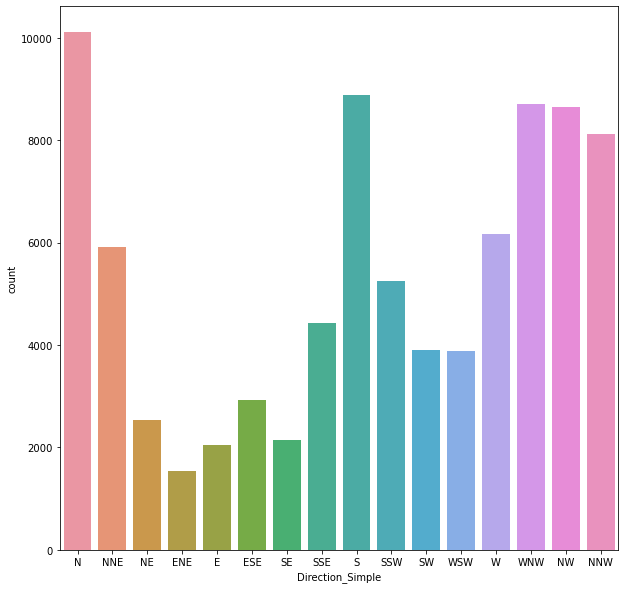

In [8]:
dffinal=pd.read_csv('dffinal.csv') #Read data back in from file dffinal.csv
display(dffinal['Direction_Simple'].value_counts()) #show number of records from each wind direction
plt.rcParams['figure.figsize'] = [10, 10] #increase figure size
wind_order = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
sns.countplot(x = "Direction_Simple", data = dffinal, order = wind_order) #plot count of data from each wind direction

plt.show()

#### The distribution of the wind is not uniform.

---
### Plot Wind Data by Direction
* Use function "plot_speed_delta"
* Function will filter data by the direction which is it given and place it into a 5 x 5 subplot
* If r^2 value is above 0.6, the background will turn light blue and the trendline will be shown.


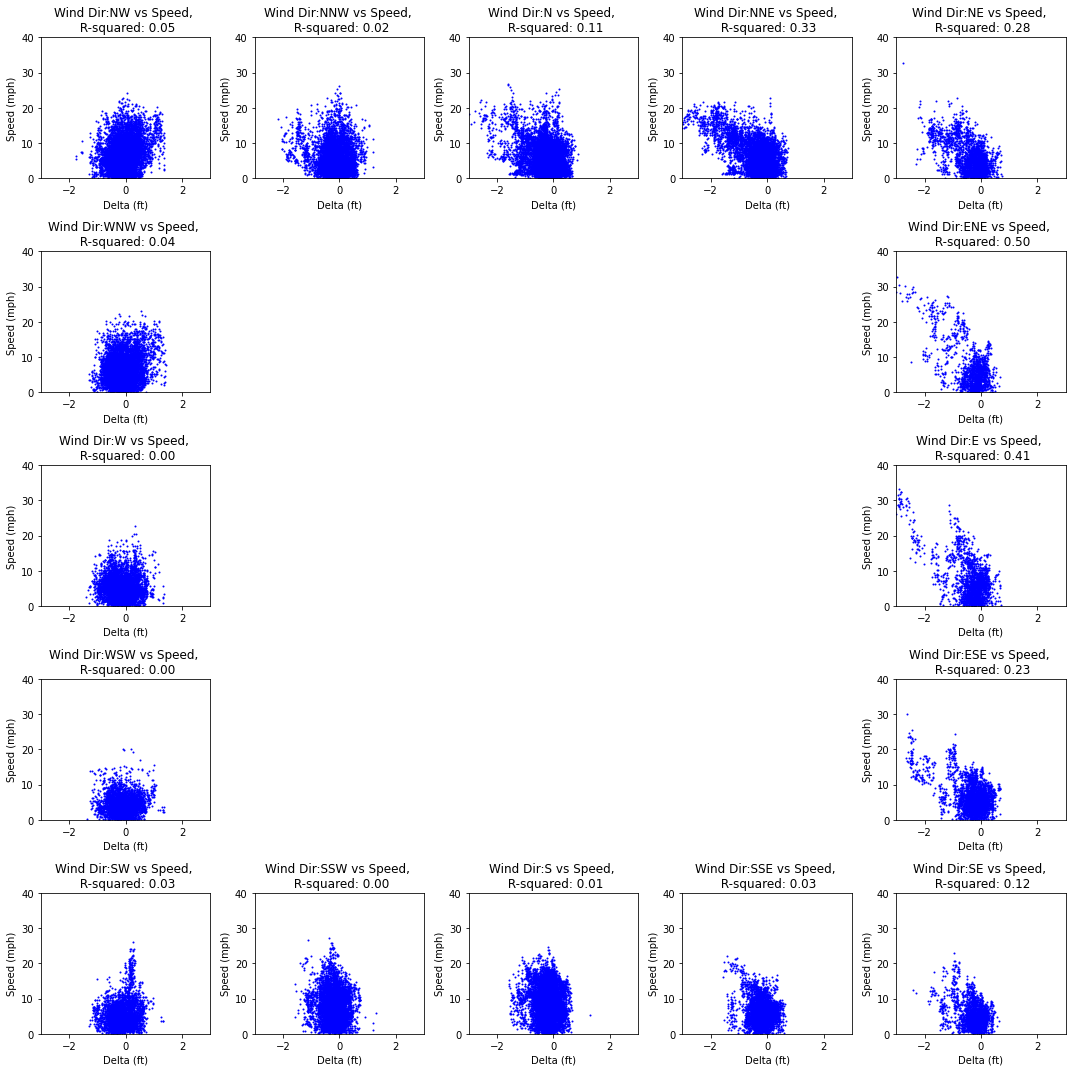

In [12]:
def plot_speed_delta(wind_direction, i):
    dffilter_orig=dffinal[(dffinal.Direction_Simple ==wind_direction)]
    
    x=dffilter_orig['Delta (ft)']
    y=dffilter_orig['Speed']
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    result = stats.linregress(x, y)    
    if result.rvalue**2>.6:
        assigncolor='lightblue'
    else:
        assigncolor='white'
    plt.subplot(5, 5, i, facecolor=assigncolor)
    plt.scatter(x,y,c='b', s=1)
    plt.xlim(-3,3)
    plt.ylim(0,40)
    plt.xlabel("Delta (ft)")
    plt.ylabel("Speed (mph)")

    r2=(f"R-squared: {result.rvalue**2:.2f}")
    if result.rvalue**2>.6:
        plt.plot(x, p(x), 'm-')
    plt.title('Wind Dir:'+str(wind_direction)+ ' vs Speed, \n ' + r2, loc='center')
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    return ()



plt.rcParams['figure.figsize'] = [15, 15]  #make figure larger
fig = plt.figure()

#plot each wind direction starting with North at 12 oclock and going around the compass rose.
plot_speed_delta('N',3)
plot_speed_delta('NNE', 4)
plot_speed_delta('NE',5)
plot_speed_delta('ENE',10)
plot_speed_delta('E',15)
plot_speed_delta('ESE',20)
plot_speed_delta('SE',25)
plot_speed_delta('SSE',24)
plot_speed_delta('S',23)
plot_speed_delta('SSW',22)
plot_speed_delta('SW',21)
plot_speed_delta('WSW',16)
plot_speed_delta('W',11)
plot_speed_delta('WNW',6)
plot_speed_delta('NW',1)
plot_speed_delta('NNW',2)

plt.show()

This produced an interesting plot, but unfortunately there wasn't a strong correlation between wind speed and shift of the predicted tide level (Delta)

The closest wind directions which may have a negative trend are those in the top right, NNE all the way to ESE

I think the data may be too noisy because the data is collected every 6 minutes and with wind speed, the wind is often changing direction fairly rapidly and the water would never react quickly enough.  For a real effect I think you'd need to consider sustained winds.

### Replot Data Filtering for More Sustained Winds

* As a trial will only plot data where the past 4 records indicating the same wind direction.  Since the data is taken every 6 minutes, this will be 24 minutes of a sustained wind direction for each data point.

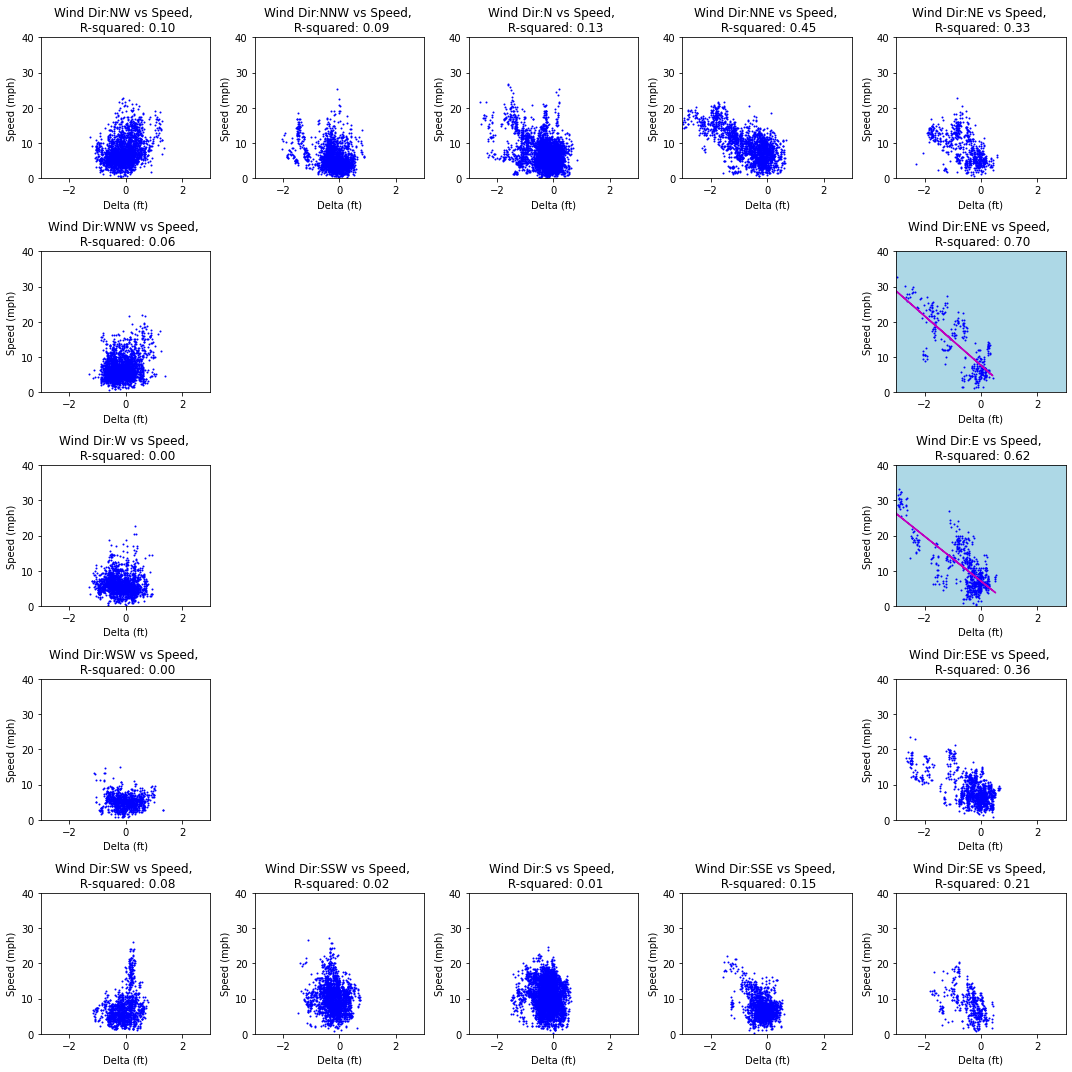

In [14]:
def plot_speed_delta2(wind_direction, i):
    dffilter=dffinal
    dffilter['Wind_Dif'] = ((dffilter['Direction_Simple']) == (dffilter['Direction_Simple'].shift(1)))
    dffilter['Wind_Dif2'] = ((dffilter['Direction_Simple']) == (dffilter['Direction_Simple'].shift(2)))
    dffilter['Wind_Dif3'] = ((dffilter['Direction_Simple']) == (dffilter['Direction_Simple'].shift(3)))
    dffilter['Wind_Dif_Result'] = ((dffilter['Wind_Dif'] == True) & (dffilter['Wind_Dif2'] == True) & (dffilter['Wind_Dif3'] == True))
    dffilter2=dffilter[(dffilter.Direction_Simple ==wind_direction) & (dffilter.Wind_Dif_Result == True)]
    
    x=dffilter2['Delta (ft)']
    y=dffilter2['Speed']
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    result = stats.linregress(x, y)    
    if result.rvalue**2>.6:
        assigncolor='lightblue'
    else:
        assigncolor='white'
    plt.subplot(5, 5, i, facecolor=assigncolor)
    plt.scatter(x,y,c='b', s=1)
    plt.xlim(-3,3)
    plt.ylim(0,40)
    plt.xlabel("Delta (ft)")
    plt.ylabel("Speed (mph)")

    r2=(f"R-squared: {result.rvalue**2:.2f}") #plot linear regression line
    if result.rvalue**2>.6:
        plt.plot(x, p(x), 'm-')
    plt.title('Wind Dir:'+str(wind_direction)+ ' vs Speed, \n ' + r2, loc='center')
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    return ()



plt.rcParams['figure.figsize'] = [15, 15]  #make figure larger
fig = plt.figure()

#plot each wind direction starting with North at 12 o'clock and going around the compass rose.
plot_speed_delta2('N',3)
plot_speed_delta2('NNE', 4)
plot_speed_delta2('NE',5)
plot_speed_delta2('ENE',10)
plot_speed_delta2('E',15)
plot_speed_delta2('ESE',20)
plot_speed_delta2('SE',25)
plot_speed_delta2('SSE',24)
plot_speed_delta2('S',23)
plot_speed_delta2('SSW',22)
plot_speed_delta2('SW',21)
plot_speed_delta2('WSW',16)
plot_speed_delta2('W',11)
plot_speed_delta2('WNW',6)
plot_speed_delta2('NW',1)
plot_speed_delta2('NNW',2)

plt.show()

This was much more promising, there is a clear trend at ENE and E.

One thing that I still notice is that the wind speed doesn't seem to affect the tide till about 10mph or so.  

### Conclusions

* Wind Direction is not evenly distributed.
* ENE and E wind directions have a negative correlation with respect to predicted tide height.
    * A 20 mph sustained wind has the effect of lowering the tide by about 2 feet.

### Recommendations for Future Work

* Consider further filtering to only consider sustained winds.  
* Bin the data differently so the range of wind directions is wider than 22.5 degrees. 
* Consider a nonlinear correlation to try to account for the lack of an effect at the lower wind speeds.